# Creating Module Files

This section creates all the Python modules used in this workflow.  
Each module handles a specific part of the pipeline, making the code modular and easier to manage.


# `data_processing.py` – Data Processing Module
This module handles common data preprocessing tasks: loading CSVs, cleaning text, parsing dates, handling missing values, filtering columns, and saving processed data.

**Functions:**

- `load_csv(file_path, do_sample=False, sample_size=3000)` – Load CSV into DataFrame, optionally sample rows.  
  - **Input:**  
    - `file_path` – Path to the CSV file  
    - `do_sample` – Whether to randomly sample rows (default `False`)  
    - `sample_size` – Number of rows to sample if `do_sample=True` (default `3000`)  
  - **Returns:** pandas DataFrame

- `parse_dates(df, col_name)` – Convert string dates to `datetime`, remove invalid rows.  
  - **Input:**  
    - `df` – pandas DataFrame  
    - `col_name` – Column containing date strings  
  - **Returns:** DataFrame with parsed dates

- `clean_text(df, text_col)` – Clean text: lowercase, remove special characters and stopwords.  
  - **Input:**  
    - `df` – pandas DataFrame  
    - `text_col` – Column containing text to clean  
  - **Returns:** DataFrame with a new `clean_text` column

- `fill_NA(df, target_col)` – Fill missing values with `"unknown"`.  
  - **Input:**  
    - `df` – pandas DataFrame  
    - `target_col` – Column to fill missing values  
  - **Returns:** Updated DataFrame

- `keep_only_columns(df, columns_to_keep)` – Keep only selected columns.  
  - **Input:**  
    - `df` – pandas DataFrame  
    - `columns_to_keep` – List of column names to retain  
  - **Returns:** Filtered DataFrame

- `write_new_file(df, filename="processed_data.csv")` – Save DataFrame to CSV.  
  - **Input:**  
    - `df` – pandas DataFrame  
    - `filename` – Output CSV file name (default `"processed_data.csv"`)  

<br>**To create the `.py` file in Colab, run:**

In [19]:
%%writefile data_processing.py

import pandas as pd
import re
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords


def load_csv(file_path, do_sample=False, sample_size=3000):
    try:
        df = pd.read_csv(file_path, low_memory=False, on_bad_lines="skip")
        print(f"Loaded {file_path} successfully.")

        if do_sample:
          if len(df) > sample_size:
            df = df.sample(n=sample_size, random_state=42)

        return df

    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def parse_dates(df, date_col):
    try:
        if date_col not in df.columns:
            raise ValueError(f"Column '{date_col}' not found in DataFrame.")
        if not isinstance(df, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame.")

        s = df[date_col].astype(str).str.strip().str.replace(r'\s+', ' ', regex=True)

        formats = [
            '%d/%m/%Y %I:%M:%S %p',
            '%d-%m-%Y %H:%M',
            '%Y-%m-%d %H:%M:%S',
            '%d/%m/%Y',
            '%Y-%m-%d'
        ]

        parsed = pd.Series([pd.NaT]*len(s), index=s.index) #create a empty list with index corresponding to df

        for fmt in formats:
            mask = parsed.isna() #find emptry space
            try:
                parsed[mask] = pd.to_datetime(s[mask], format=fmt, errors='coerce') #try convert date object
            except:
                continue

        df[date_col] = parsed

    except Exception as e:
        print(f"Error parse_dates: {e}")

    return df[df[date_col].notna()]

def clean_text(df, text_col):
    try:
        if text_col not in df.columns:
            raise ValueError(f"Column '{text_col}' not found in DataFrame.")
        if not isinstance(df, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame.")


        stop_words = set(stopwords.words('english'))

        def _clean_single_text(text):
            if not isinstance(text, str):
                return ""
            text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)
            text = text.lower()
            text = " ".join([word for word in text.split() if word not in stop_words])
            return text

        df['clean_text'] = df[text_col].apply(_clean_single_text)
        return df

    except Exception as e:
        print(f"Error in clean_text: {e}")
        return df

def fill_NA(df, target_col):
    try:
        if target_col not in df.columns:
            raise ValueError(f"Column '{target_col}' not found in DataFrame.")
        if not isinstance(df, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame.")

        df[target_col] = df[target_col].fillna("unknown")
        return df

    except Exception as e:
        print(f"Error in fill_NA: {e}")
        return df

def keep_only_columns(df, columns_to_keep):
    try:
        if not isinstance(df, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame.")
        if not isinstance(columns_to_keep, list):
            raise TypeError("columns_to_keep must be a list.")

        #keep only columns that exist in the DataFrame
        existing_cols = [col for col in columns_to_keep if col in df.columns]
        return df[existing_cols]

    except Exception as e:
        print(f"Error: {e}")
        return df

def write_new_file(df, filename="processed_data.csv"):
      try:
        df.to_csv(filename, index=False, encoding="utf-8")
        print(f"File successfully saved as {filename}")
      except Exception as e:
        print(f"Error saving file: {e}")


Overwriting data_processing.py


# `sentiment_analyzer.py` – Sentiment Analysis Module

This module performs sentiment analysis on text data in a DataFrame using a pre-trained multilingual BERT model.

**Functions:**

- `analyze_sentiment(df, target_col)` – Analyze text in the specified column and add sentiment labels and numeric scores.  
  - **Input:**  
    - `df` – pandas DataFrame containing text data  
    - `target_col` – Name of the column with text to analyze  
  - **Returns:** DataFrame with two new columns:  
    - `sentiment` – Sentiment label (e.g., '1 star', '5 stars')  
    - `sentiment_score` – Numeric score extracted from the label

<br>**To create the `.py` file in Colab, run:**

In [20]:
%%writefile sentiment_analyzer.py
from transformers import pipeline
import pandas as pd

sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

def analyze_sentiment(df, target_col):
    try:
        if not isinstance(df, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame.")
        if target_col not in df.columns:
            raise ValueError(f"Column '{target_col}' not found in DataFrame.")

        df["sentiment"] = df[target_col].apply(lambda x: sentiment_pipeline(str(x))[0]['label'])
        df["sentiment_score"] = df["sentiment"].str[0].astype(int)

        return df

    except Exception as e:
        print(f"Error in analyze_sentiment: {e}")
        return df

Overwriting sentiment_analyzer.py


# `visualizer.py` – Data Visualization Module

This module provides functions for visualizing data, including pie charts and sentiment trends over time.

**Functions:**

- `plot_pie(df, value_col, title)` – Generate a pie chart showing distribution of values in a column.  
  - **Input:**  
    - `df` – pandas DataFrame  
    - `value_col` – Column to visualize  
    - `title` – Chart title  
  - **Returns:** None (displays a pie chart)

- `plot_sentiment_trend(df, date_col, sentiment_col)` – Plot monthly average sentiment over time with post counts.  
  - **Input:**  
    - `df` – pandas DataFrame  
    - `date_col` – Column containing datetime values  
    - `sentiment_col` – Column containing sentiment scores  
  - **Returns:** None (displays a line chart with annotations)

<br>**To create the `.py` file in Colab, run:**

In [21]:
%%writefile visualizer.py
import matplotlib.pyplot as plt
import pandas as pd

def plot_pie(df, value_col, title):
    try:
        if not isinstance(df, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame.")
        if value_col not in df.columns:
            raise ValueError(f"Column '{value_col}' not found in DataFrame.")

        counts = df[value_col].value_counts()
        counts.plot(kind="pie", autopct='%1.1f%%', startangle=90, figsize=(15,15))
        plt.title(title)
        plt.ylabel("")
        plt.show()

    except Exception as e:
        print(f"Error generating pie chart: {e}")

def plot_sentiment_trend(df, date_col, sentiment_col):
    try:
        if not isinstance(df, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame.")
        if date_col not in df.columns:
            raise ValueError(f"Column '{date_col}' not found in DataFrame.")
        if sentiment_col not in df.columns:
            raise ValueError(f"Column '{sentiment_col}' not found in DataFrame.")

        df_copy = df.copy()

        #grp by year month
        df_copy['year_month'] = df_copy[date_col].dt.to_period('M')
        monthly = df_copy.groupby('year_month').agg({sentiment_col: ['mean', 'count']})
        monthly.columns = ['avg_sentiment', 'count']

        monthly = monthly.reset_index()
        monthly['year_month'] = monthly['year_month'].astype(str)
        monthly = monthly.sort_values('year_month')

        #plot average sentiment
        plt.figure(figsize=(14, 6))
        plt.plot(monthly['year_month'], monthly['avg_sentiment'], marker='o', linestyle='-')
        plt.title(f"Monthly Average Sentiment ({sentiment_col})")
        plt.xlabel("Month")
        plt.ylabel(f"Average {sentiment_col}")

        #add number of post to each month
        for i, row in monthly.iterrows():
            plt.text(i, row['avg_sentiment'] + 0.05, str(row['count']), ha='center', va='bottom', fontsize=8)

        plt.text(len(monthly)-1, monthly['avg_sentiment'].max() + 0.25, "Number above each point = number of posts in that month", fontsize=9, ha='right')

        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error generating sentiment trend: {e}")

Overwriting visualizer.py


# `main.py` – Main Script

This script runs the full workflow:  
1. Load and preprocess the CSV data.  
2. Perform sentiment analysis on text and save the processed data to a CSV file.
3. Generate visualizations (pie chart and sentiment trend).

**To run the script:**  
Make sure the CSV data (`covidvaccine.csv`) exists in the working directory and all module files (`data_processing.py`, `sentiment_analyzer.py`, `visualizer.py`) are present. Then, you can execute `main.py` directly.

<br>**To create the `.py` file in Colab, run:**

In [22]:
%%writefile main.py
import pandas as pd
import data_processing as dp
import sentiment_analyzer as sa
import visualizer as v

def run():
    #load and clean data
    df = dp.load_csv('covidvaccine.csv', True, 1000)
    df = dp.parse_dates(df,'date')
    df = dp.clean_text(df,'text')
    df = dp.fill_NA(df,'user_name')
    df = dp.keep_only_columns(df,['user_name','date','text','clean_text'])

    #perform sentiment analysis
    df = sa.analyze_sentiment(df,'clean_text')
    dp.write_new_file(df)

    #visualizations
    v.plot_pie(df,'sentiment_score','sentiment pie chart')
    v.plot_sentiment_trend(df,'date','sentiment_score')

if __name__ == "__main__":
    run()

Overwriting main.py


---
# Modular Workflow

The main script has been split into smaller, self-contained cells that can be run independently in this notebook.<br>
Before running, ensure that all the code above has been executed and the CSV file (`covidvaccine.csv`) is available in the working directory.<br>
This allows you to execute the workflow step by step.


# Step 1: Data Loading and Cleaning

This cell loads the CSV file (`covidvaccine.csv`), samples 1000 rows, parses the `date` column, cleans the `text` column, fills missing `user_name` values, and keeps only the selected columns.  
At the end, it prints basic information about the DataFrame to verify the loaded and cleaned data.


In [5]:
import importlib
import pandas as pd
import data_processing as dp


importlib.reload(dp)

df = dp.load_csv('covidvaccine.csv',True,1000)
df = dp.parse_dates(df,'date')
df = dp.clean_text(df,'text')
df = dp.fill_NA(df,'user_name')
df = dp.keep_only_columns(df,['user_name','date','text','clean_text'])


if df is not None:
    print(df.info())
else:
    print("DataFrame could not be loaded.")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loaded covidvaccine.csv successfully.
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 145491 to 63064
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_name   1000 non-null   object        
 1   date        1000 non-null   datetime64[ns]
 2   text        1000 non-null   object        
 3   clean_text  1000 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 71.4+ KB
None


# Step 2: Sentiment Analysis

This cell performs sentiment analysis on the `clean_text` column using the `sentiment_analyzer` module.  
After analysis, the results are saved to a CSV file.

In [6]:
import sentiment_analyzer as sa

importlib.reload(sa)

df = sa.analyze_sentiment(df,'clean_text')
dp.write_new_file(df)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu
Device set to use cpu


File successfully saved as processed_data.csv


# Step 3: Visualizations

This cell generates visualizations using the `visualizer` module:  
1. A pie chart showing the distribution of sentiment scores.  
2. A line chart showing the monthly average sentiment trend with post counts.

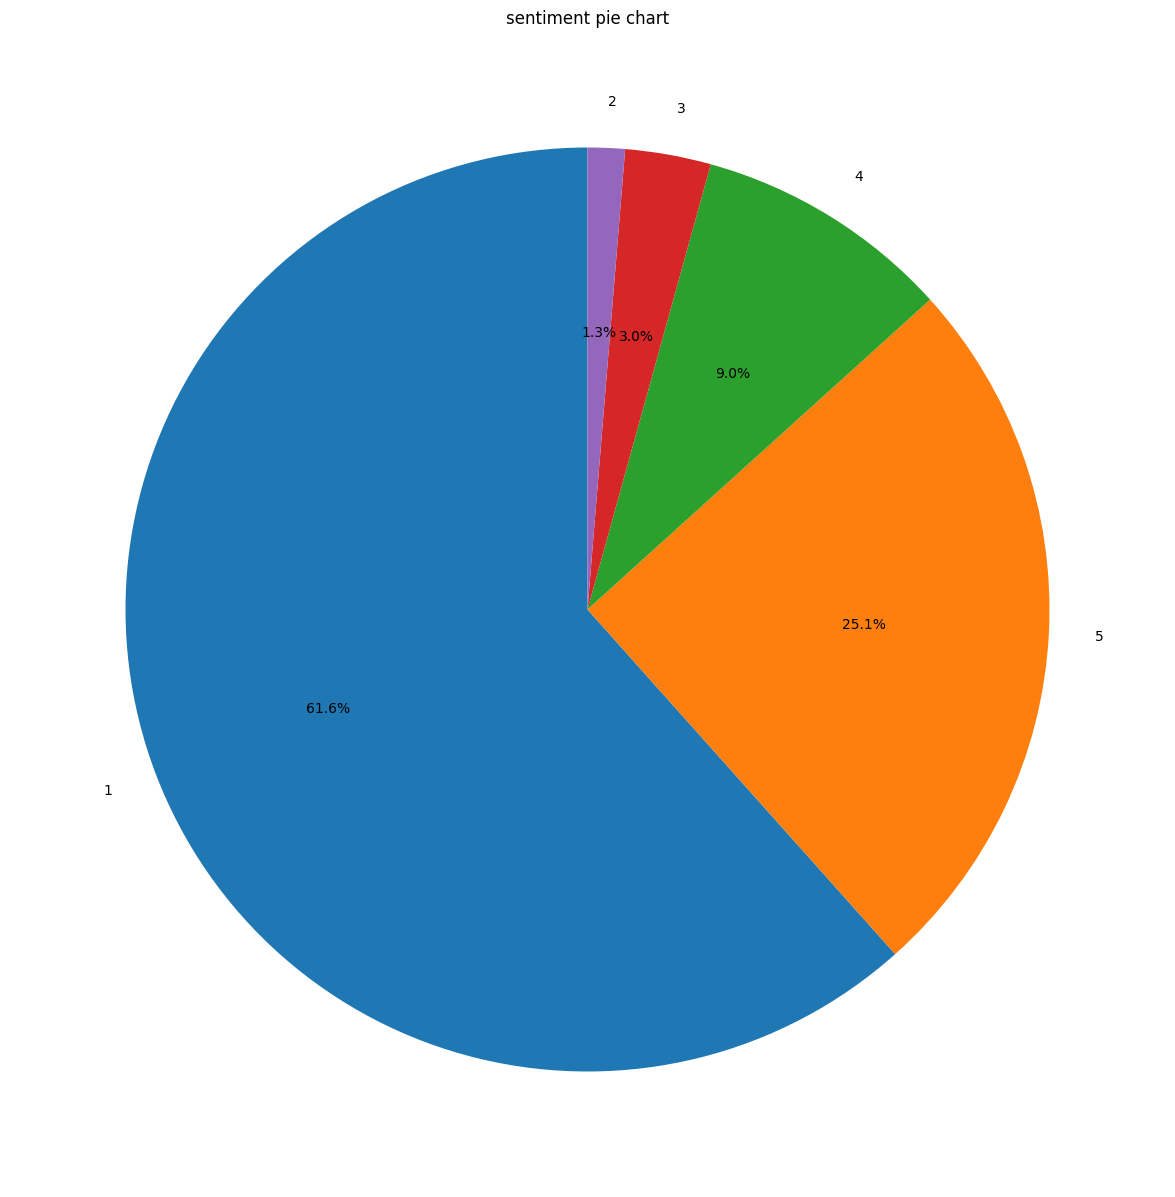

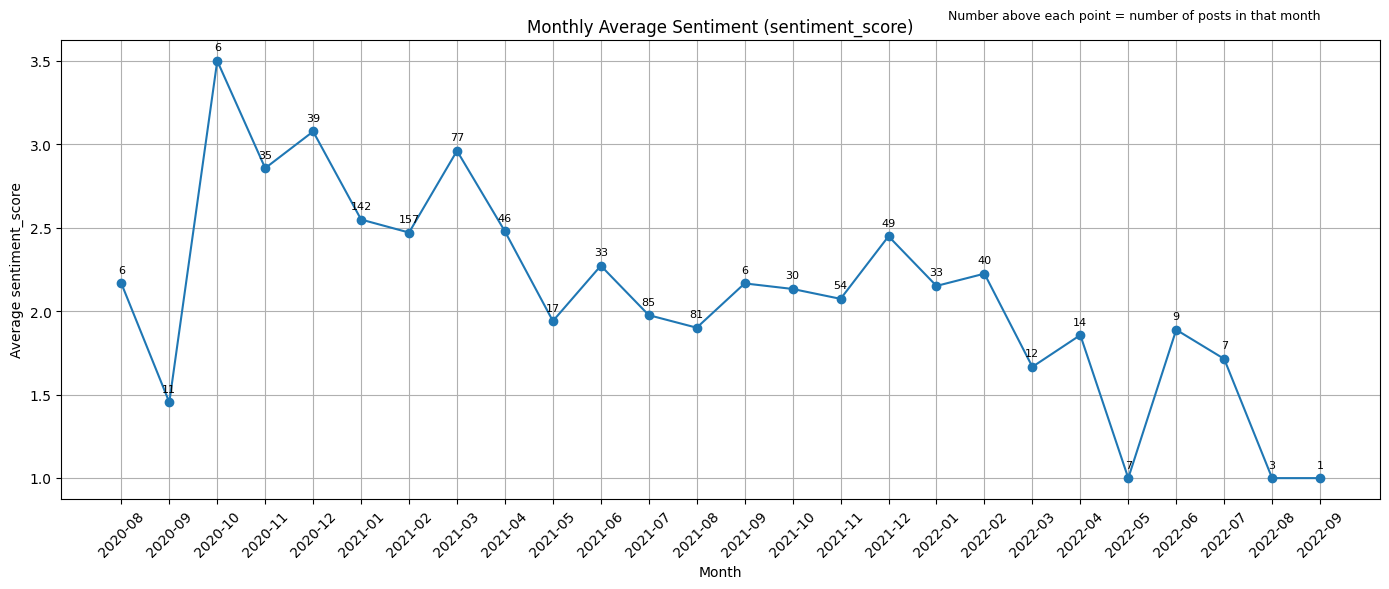

In [18]:
import visualizer as v

importlib.reload(v)
v.plot_pie(df,'sentiment_score','sentiment pie chart')
v.plot_sentiment_trend(df,'date','sentiment_score')